# Sparkify Capstone Project

First pip install pyspark if it is not already installed

In [1]:
!pip install pyspark

We need to first load in the necessary pyspark libaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as _sum
from pyspark.sql.types import FloatType

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.linalg import Vectors

In [3]:
spark = SparkSession \
    .builder \
    .appName("Data Frames practice") \
    .getOrCreate()

user_event_data = spark.read.json("/Users/hk720x/Documents/GitHub/Sparkify_Churn/full_sparkify_event_data.json")

# Data Exploration

In [4]:
user_event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
user_event_data.show(1)

+---------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|   artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+---------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|Popol Vuh|Logged In|    Shlok|     M|          278| Johnson|524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|
+---------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+-

In [6]:
user_event_data.count()

26259199

### Most Visited Pages

In [7]:
user_event_data.groupBy('page') \
  .count()\
  .sort(desc("count"))\
  .show(25)

+--------------------+--------+
|                page|   count|
+--------------------+--------+
|            NextSong|20850272|
|                Home| 1343102|
|           Thumbs Up| 1151465|
|     Add to Playlist|  597921|
|         Roll Advert|  385212|
|          Add Friend|  381664|
|               Login|  296350|
|              Logout|  296005|
|         Thumbs Down|  239212|
|           Downgrade|  184240|
|                Help|  155100|
|            Settings|  147074|
|               About|   92759|
|             Upgrade|   50507|
|       Save Settings|   29516|
|               Error|   25962|
|      Submit Upgrade|   15135|
|    Submit Downgrade|    6494|
|              Cancel|    5003|
|Cancellation Conf...|    5003|
|            Register|     802|
| Submit Registration|     401|
+--------------------+--------+



### User IDs
Lets investigate how many users we have in the dataset and if there are any obvious things we need to clean up

In [8]:
user_event_data.select('userId')\
  .dropDuplicates()\
  .count()

22278

In [9]:
user_event_data.groupBy('userId') \
  .count()\
  .sort(desc("count"))\
  .show(5)

+-------+------+
| userId| count|
+-------+------+
|1261737|778479|
|1564221| 13591|
|1931933| 12831|
|1006695| 12372|
|1336969| 11858|
+-------+------+
only showing top 5 rows



In [11]:
user_event_valid_id = user_event_data.dropna(how = "any", subset = ["userId", "sessionId"])
user_event_valid_id = user_event_valid_id.filter(user_event_valid_id["userId"] != "")

### Churned Users Counts

In [12]:
user_event_valid_id.filter(user_event_valid_id.page=='Cancellation Confirmation') \
  .groupBy('gender') \
  .count()\
  .show(2)

+------+-----+
|gender|count|
+------+-----+
|     F| 2347|
|     M| 2656|
+------+-----+



# Create Truth Set
Determine the users that are cancelling their services (Churning) and label them as 1 and those that havent cancelled their service as 0

In [13]:
labeled_df = user_event_valid_id.withColumn('churned', (when(col('page')== 'Cancellation Confirmation',1)\
                                                            .otherwise(0)))
                                            

In [14]:
user_labeled_df = labeled_df.groupby('userId')\
                       .agg(_sum('churned')\
                       .alias('churned'))

In [15]:
user_labeled_df.show(2)

+-------+-------+
| userId|churned|
+-------+-------+
|1390009|      1|
|1519090|      0|
+-------+-------+
only showing top 2 rows



In [16]:
user_labeled_df.groupBy('churned')\
               .count()\
               .show()

+-------+-----+
|churned|count|
+-------+-----+
|      0|17275|
|      1| 5003|
+-------+-----+



Out of our total number of 448 users 349 are subscribers and 99 are no longer subscribers and have churned. This is a bit unbalanced but not as bad as many fraud datasets. What is not ideal for a machine learning algorithm is that despite starting with what seemed to be a resonably large dataset of 543705 rows of logs there are effectively only 448 data points in our model. 

#### EDA Chart Churn by Gender

In [17]:
eda = user_labeled_df.join(user_event_valid_id, on = 'userId')\
                        .select('userId','gender','churned')\
                        .dropDuplicates()\
                        .groupBy('gender','churned')\
                        .count()\
                        .toPandas()

In [ ]:
eda

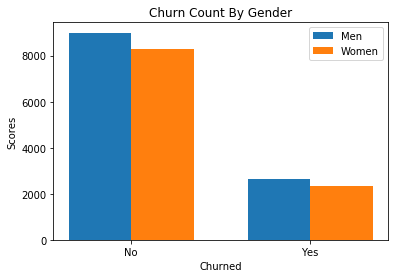

In [18]:
N = 2
men_count = eda[eda.gender=="M"]['count']
women_count = eda[eda.gender=="F"]['count']

total_count = men_count.reset_index(drop = True) + women_count.reset_index(drop = True)


ind = np.arange(N) 
width = 0.35       
plt.bar(ind, men_count, width, label='Men')
plt.bar(ind + width, women_count, width,
    label='Women')

plt.ylabel('Scores')
plt.xlabel('Churned')
plt.title('Churn Count By Gender')

plt.xticks(ind + width / 2, ('No', 'Yes'))
plt.legend(loc='best')
plt.show()

In [19]:
total_count

0        NaN
1    10935.0
2        NaN
Name: count, dtype: float64

In [20]:
men_count

3    8995
4    2656
Name: count, dtype: int64

In [21]:
women_count

1    8279
2    2347
Name: count, dtype: int64

# Generate User Behavior Features
Now that we have the user truth values we need to generate aggregated features about the user behavior that we know before the user decides to churn. We will then use those features to predict if a user will churn based on their behavior. This will allow us to potentially keep more customers on our service and grow revenue and profit for the company.

## Feature 1 : Count of Thumbs:  up / down / total
I think that the more a user gives songs thumbs up the less likely they are to churn and the more they give songs thumbs down the more likely they are to churn

### 1.a countThumbsUp
a count of the times a user has given a thumbs up

In [22]:
# Thumbs Up
labeled_df = labeled_df.withColumn('ThumbsUp', (when(col('page')== 'Thumbs Up',1)\
                                                            .otherwise(0)))
user_thumbsUp_df = labeled_df.groupby('userId')\
                       .agg(_sum('ThumbsUp')\
                       .alias('countThumbsUp'))

##### Feature Summary

In [23]:
user_thumbsUp_df.dropDuplicates()\
                .describe('countThumbsUp')\
                .show()

+-------+------------------+
|summary|     countThumbsUp|
+-------+------------------+
|  count|             22278|
|   mean|51.686192656432354|
| stddev| 64.58884961218529|
|    min|                 0|
|    max|               836|
+-------+------------------+



In [24]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(user_thumbsUp_df, 'userId')
user_labeled_df.show(5)

+-------+-------+-------------+
| userId|churned|countThumbsUp|
+-------+-------+-------------+
|1000280|      1|           53|
|1002185|      0|           92|
|1017805|      0|            7|
|1030587|      0|           66|
|1033297|      0|           10|
+-------+-------+-------------+
only showing top 5 rows



#### EDA of Count of Thumbs Up

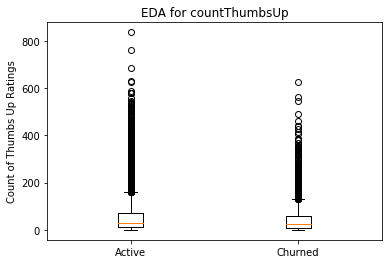

Median for Active subscribers: 31.0
Median for Churned subscribers: 25.0


In [25]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countThumbsUp.values, 'Churned': churn.countThumbsUp.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countThumbsUp")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Thumbs Up Ratings")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countThumbsUp.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countThumbsUp.values),3))

### 1.b countThumbsDown
a count of the times a user has given a thumbs down

In [26]:
# Thumbs Down
labeled_df = labeled_df.withColumn('ThumbsDown', (when(col('page')== 'Thumbs Down',1)\
                                                            .otherwise(0)))
user_thumbsDown_df = labeled_df.groupby('userId')\
                       .agg(_sum('ThumbsDown')\
                       .alias('countThumbsDown'))

##### Feature Summary

In [27]:
user_thumbsDown_df.dropDuplicates()\
                .describe('countThumbsDown')\
                .show()

+-------+------------------+
|summary|   countThumbsDown|
+-------+------------------+
|  count|             22278|
|   mean| 10.73758865248227|
| stddev|12.615942418588652|
|    min|                 0|
|    max|               154|
+-------+------------------+



In [28]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(user_thumbsDown_df, 'userId')
user_labeled_df.show(5)

+-------+-------+-------------+---------------+
| userId|churned|countThumbsUp|countThumbsDown|
+-------+-------+-------------+---------------+
|1000280|      1|           53|             33|
|1002185|      0|           92|             14|
|1017805|      0|            7|              4|
|1030587|      0|           66|             16|
|1033297|      0|           10|              3|
+-------+-------+-------------+---------------+
only showing top 5 rows



#### EDA of Count of Thumbs Down

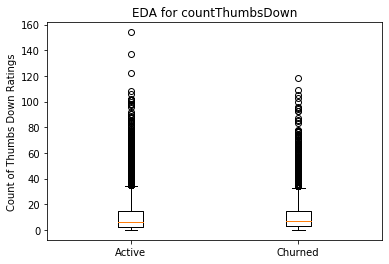

Median for Active subscribers: 6.0
Median for Churned subscribers: 7.0


In [29]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countThumbsDown.values, 'Churned': churn.countThumbsDown.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countThumbsDown")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Thumbs Down Ratings")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countThumbsDown.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countThumbsDown.values),3))

#### EDA Chart Churn and Count of Thumbs Up / Thumbs Down

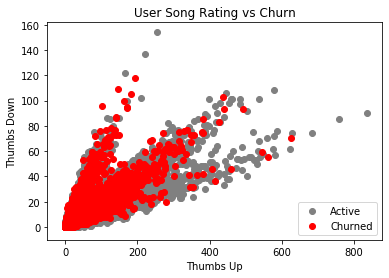

In [30]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plt.scatter(noChurn.countThumbsUp,noChurn.countThumbsDown,color='gray',label='Active')
plt.scatter(churn.countThumbsUp,churn.countThumbsDown,color='red',label='Churned')

plt.ylabel('Thumbs Down')
plt.xlabel('Thumbs Up')
plt.title('User Song Rating vs Churn')
plt.legend(loc='lower right')
plt.show()

### 1.c Total Thumbs
Another easy feature to add is total between thumbs up and thumbs down. This can allow us to create percentage based features for users that are

In [31]:
user_labeled_df = user_labeled_df.withColumn('totalThumbs',user_labeled_df.countThumbsUp + user_labeled_df.countThumbsDown)
user_labeled_df.show(5)

+-------+-------+-------------+---------------+-----------+
| userId|churned|countThumbsUp|countThumbsDown|totalThumbs|
+-------+-------+-------------+---------------+-----------+
|1000280|      1|           53|             33|         86|
|1002185|      0|           92|             14|        106|
|1017805|      0|            7|              4|         11|
|1030587|      0|           66|             16|         82|
|1033297|      0|           10|              3|         13|
+-------+-------+-------------+---------------+-----------+
only showing top 5 rows



##### Feature Summary

In [32]:
user_labeled_df.describe('totalThumbs')\
               .show()

+-------+-----------------+
|summary|      totalThumbs|
+-------+-----------------+
|  count|            22278|
|   mean|62.42378130891463|
| stddev| 75.3224106826546|
|    min|                0|
|    max|              926|
+-------+-----------------+



#### EDA Chart Churn and Count of Logins

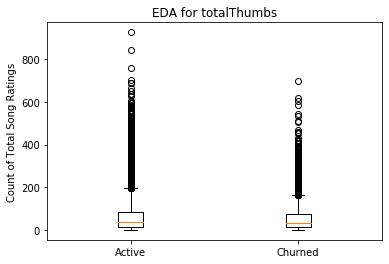

Median for Active subscribers: 38.0
Median for Churned subscribers: 33.0


In [33]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.totalThumbs.values, 'Churned': churn.totalThumbs.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for totalThumbs")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Total Song Ratings")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.totalThumbs.values),3))
print("Median for Churned subscribers:",round(np.median(churn.totalThumbs.values),3))

## Feature 2 : Number of Logins
I assume that the more a user engages with the service the more likely they are to not churn

In [34]:

num_logins_df = user_event_valid_id\
                   .select('userId','sessionId')\
                   .dropDuplicates()\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countLogins")

##### Feature Summary

In [35]:
num_logins_df.describe('countLogins')\
             .show()

+-------+------------------+
|summary|       countLogins|
+-------+------------------+
|  count|             22278|
|   mean|20.431726366819284|
| stddev|1059.3297847404108|
|    min|                 1|
|    max|            158115|
+-------+------------------+



In [36]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(num_logins_df, 'userId')
user_labeled_df.show(5)

+-------+-------+-------------+---------------+-----------+-----------+
| userId|churned|countThumbsUp|countThumbsDown|totalThumbs|countLogins|
+-------+-------+-------------+---------------+-----------+-----------+
|1000280|      1|           53|             33|         86|         22|
|1002185|      0|           92|             14|        106|         17|
|1017805|      0|            7|              4|         11|          3|
|1030587|      0|           66|             16|         82|         11|
|1033297|      0|           10|              3|         13|          5|
+-------+-------+-------------+---------------+-----------+-----------+
only showing top 5 rows



#### EDA Chart Churn and Count of Total Ratings

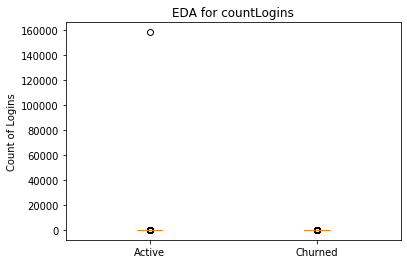

Median for Active subscribers: 10.0
Median for Churned subscribers: 8.0


In [37]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countLogins.values, 'Churned': churn.countLogins.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countLogins")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Logins")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countLogins.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countLogins.values),3))

## Feature 3 : Number of Friends
I assume that the more friends a user has the more likely they will stay on our service. 

In [38]:
num_friends_df = user_event_valid_id\
                   .filter(user_event_valid_id.page=="Add Friend")\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countFriends")

##### Feature Summary

In [39]:
num_friends_df.describe('countFriends')\
              .show()

+-------+-----------------+
|summary|     countFriends|
+-------+-----------------+
|  count|            20305|
|   mean|18.79655257325782|
| stddev|20.74770411629507|
|    min|                1|
|    max|              222|
+-------+-----------------+



In [40]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(num_friends_df, 'userId', how='left').fillna(0)
user_labeled_df.show(5)

+-------+-------+-------------+---------------+-----------+-----------+------------+
| userId|churned|countThumbsUp|countThumbsDown|totalThumbs|countLogins|countFriends|
+-------+-------+-------------+---------------+-----------+-----------+------------+
|1000280|      1|           53|             33|         86|         22|          14|
|1002185|      0|           92|             14|        106|         17|          25|
|1017805|      0|            7|              4|         11|          3|          13|
|1030587|      0|           66|             16|         82|         11|          23|
|1033297|      0|           10|              3|         13|          5|           4|
+-------+-------+-------------+---------------+-----------+-----------+------------+
only showing top 5 rows



#### EDA Chart Churn and Number of Friends

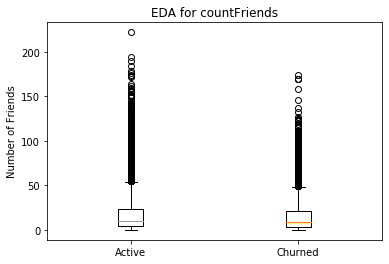

Median Active subscribers: 10.0
Median Churned subscribers: 9.0


In [41]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countFriends.values, 'Churned': churn.countFriends.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countFriends")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Number of Friends")
plt.show()
print("Median Active subscribers:",round(np.median(noChurn.countFriends.values),3))
print("Median Churned subscribers:",round(np.median(churn.countFriends.values),3))

## Feature 4 : Number of Errors
I assume that the more errors a user faces especially compared to the number of songs they listen to the more likely they are to churn

In [42]:
num_errors_df = user_event_valid_id\
                   .filter(user_event_valid_id.page=="Error")\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countErrors")

##### Feature Summary

In [43]:
num_errors_df.describe('countErrors')\
              .show()

+-------+------------------+
|summary|       countErrors|
+-------+------------------+
|  count|             11273|
|   mean|2.3030249268162866|
| stddev| 8.761906969237886|
|    min|                 1|
|    max|               914|
+-------+------------------+



In [44]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(num_errors_df, 'userId', how='left').fillna(0)
user_labeled_df.show(5)

+-------+-------+-------------+---------------+-----------+-----------+------------+-----------+
| userId|churned|countThumbsUp|countThumbsDown|totalThumbs|countLogins|countFriends|countErrors|
+-------+-------+-------------+---------------+-----------+-----------+------------+-----------+
|1000280|      1|           53|             33|         86|         22|          14|          3|
|1002185|      0|           92|             14|        106|         17|          25|          2|
|1017805|      0|            7|              4|         11|          3|          13|          0|
|1030587|      0|           66|             16|         82|         11|          23|          1|
|1033297|      0|           10|              3|         13|          5|           4|          0|
+-------+-------+-------------+---------------+-----------+-----------+------------+-----------+
only showing top 5 rows



#### EDA Chart Churn and Count of Errors

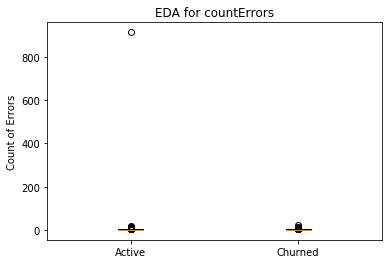

Median for Active subscribers: 1.0
Median for Churned subscribers: 0.0


In [45]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countErrors.values, 'Churned': churn.countErrors.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countErrors")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Errors")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countErrors.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countErrors.values),3))

## Feature 5 : Number of visits to the help page
I assume that the more visits to the help page the more likely a user is to be having trouble with the service and is thus more likely to leave

In [46]:
num_help_df = user_event_valid_id\
                   .filter(user_event_valid_id.page=="Help")\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countHelp")

##### Feature Summary

In [47]:
num_help_df.describe('countHelp')\
              .show()

+-------+-----------------+
|summary|        countHelp|
+-------+-----------------+
|  count|            18244|
|   mean|8.501425126068845|
| stddev|190.0036248544131|
|    min|                1|
|    max|            25652|
+-------+-----------------+



In [48]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(num_help_df, 'userId', how='left').fillna(0)
user_labeled_df.show(5)

+-------+-------+-------------+---------------+-----------+-----------+------------+-----------+---------+
| userId|churned|countThumbsUp|countThumbsDown|totalThumbs|countLogins|countFriends|countErrors|countHelp|
+-------+-------+-------------+---------------+-----------+-----------+------------+-----------+---------+
|1000280|      1|           53|             33|         86|         22|          14|          3|        8|
|1002185|      0|           92|             14|        106|         17|          25|          2|       12|
|1017805|      0|            7|              4|         11|          3|          13|          0|        1|
|1030587|      0|           66|             16|         82|         11|          23|          1|       10|
|1033297|      0|           10|              3|         13|          5|           4|          0|        2|
+-------+-------+-------------+---------------+-----------+-----------+------------+-----------+---------+
only showing top 5 rows



#### EDA Chart Churn and Count of Help Page Visits

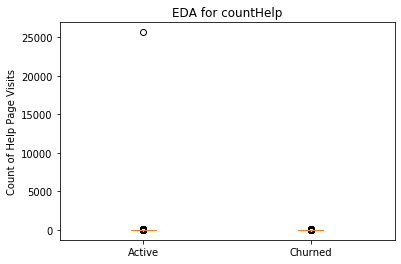

Median for Active subscribers: 3.0
Median for Churned subscribers: 3.0


In [49]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countHelp.values, 'Churned': churn.countHelp.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countHelp")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Help Page Visits")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countHelp.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countHelp.values),3))

## Feature 6 : Number of Songs
If a user listens to a lot of songs they are likely to be engaged and probably enjoy using the service

In [50]:
num_songs_df = user_event_valid_id\
                   .select('userId','song')\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countSong")

#### Feature Summary

In [51]:
num_songs_df.describe('countSong')\
              .show()

+-------+------------------+
|summary|         countSong|
+-------+------------------+
|  count|             22278|
|   mean|1178.7054044348686|
| stddev| 5372.959939882274|
|    min|                 1|
|    max|            778479|
+-------+------------------+



In [52]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(num_songs_df, 'userId')

#### EDA Chart Churn and Count of Songs A User Has Listened To

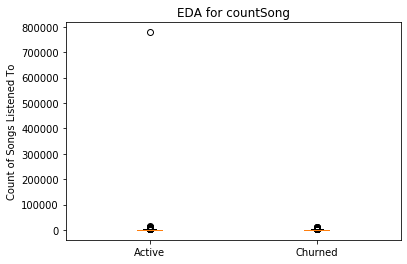

Median for Active subscribers: 702.0
Median for Churned subscribers: 646.0


In [53]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.countSong.values, 'Churned': churn.countSong.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for countSong")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Count of Songs Listened To")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.countSong.values),3))
print("Median for Churned subscribers:",round(np.median(churn.countSong.values),3))

## Feature 7 : Percent of Sessions Paid vs Free


In [54]:
mean_level_df = user_event_valid_id\
                   .select('userId','level')\
                   .withColumn('levelBinary', (when(col('level')== 'free',0)\
                                                            .otherwise(1)))\
                   .groupBy('userId')\
                   .agg(avg('levelBinary')\
                       .alias('meanLevel'))

#### Feature Summary

In [55]:
mean_level_df.describe('meanLevel')\
              .show()

+-------+-------------------+
|summary|          meanLevel|
+-------+-------------------+
|  count|              22278|
|   mean| 0.5692392364784483|
| stddev|0.40865613731057543|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [56]:
# Join data back to our user dataframe
user_labeled_df = user_labeled_df.join(mean_level_df, 'userId')

#### EDA Chart Churn and Percent of Time on Paid vs Free Subscription

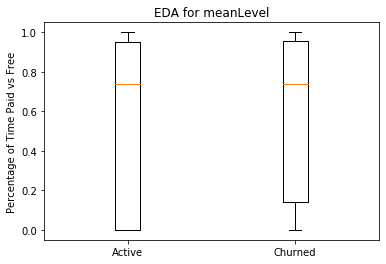

Median for Active subscribers: 0.74
Median for Churned subscribers: 0.74


In [57]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.meanLevel.values, 'Churned': churn.meanLevel.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for meanLevel")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Percentage of Time Paid vs Free")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.meanLevel.values),3))
print("Median for Churned subscribers:",round(np.median(churn.meanLevel.values),3))

In [58]:
user_labeled_df.count()

22278

## Interaction Features
The way features interact with eachother may be useful like the number of errors in a session or the percentage of thumbs up vs thumbs down a user gives to songs.

In [59]:
user_labeled_df = user_labeled_df.withColumn('percThumbsUp',\
                                             user_labeled_df.countThumbsUp / user_labeled_df.totalThumbs)\
                                 .fillna(0)

#### EDA Chart Churn and Percent of Ratings that are Thumbs Up

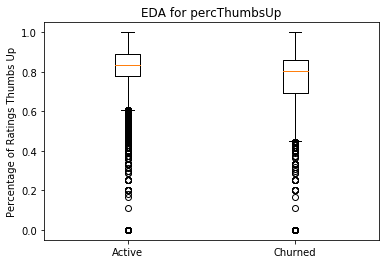

Median for Active subscribers: 0.836
Median for Churned subscribers: 0.804


In [60]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.percThumbsUp.values, 'Churned': churn.percThumbsUp.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for percThumbsUp")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Percentage of Ratings Thumbs Up")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.percThumbsUp.values),3))
print("Median for Churned subscribers:",round(np.median(churn.percThumbsUp.values),3))

In [61]:
user_labeled_df = user_labeled_df.withColumn('errorsPerLogin',\
                                             user_labeled_df.countErrors / user_labeled_df.countLogins)

#### EDA Chart Churn and Errors per Login

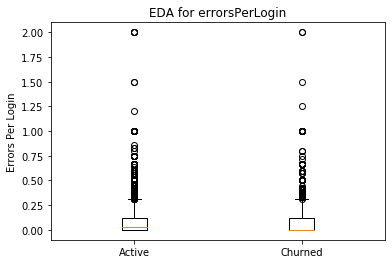

Median for Active subscribers: 0.031
Median for Churned subscribers: 0.0


In [62]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.errorsPerLogin.values, 'Churned': churn.errorsPerLogin.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for errorsPerLogin")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Errors Per Login")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.errorsPerLogin.values),3))
print("Median for Churned subscribers:",round(np.median(churn.errorsPerLogin.values),3))

In [63]:
user_labeled_df = user_labeled_df.withColumn('helpPerLogin',\
                                             user_labeled_df.countHelp / user_labeled_df.countLogins)

#### EDA Chart Churn and Help Page Visits per Login

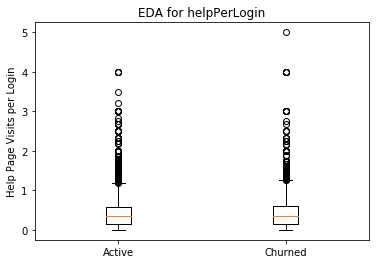

Median for Active subscribers: 0.35
Median for Churned subscribers: 0.357


In [64]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.helpPerLogin.values, 'Churned': churn.helpPerLogin.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for helpPerLogin")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Help Page Visits per Login")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.helpPerLogin.values),3))
print("Median for Churned subscribers:",round(np.median(churn.helpPerLogin.values),3))

In [65]:
user_labeled_df = user_labeled_df.withColumn('songsPerLogin',\
                                             user_labeled_df.countSong / user_labeled_df.countLogins)

#### EDA Chart Churn and Songs per Login

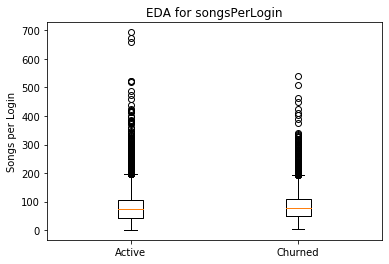

Median for Active subscribers: 72.688
Median for Churned subscribers: 76.0


In [66]:
eda = user_labeled_df.toPandas()
churn = eda[eda.churned==1]
noChurn = eda[eda.churned==0]

plot_dict = {'Active': noChurn.songsPerLogin.values, 'Churned': churn.songsPerLogin.values}
plt.boxplot(plot_dict.values())

plt.title("EDA for songsPerLogin")
plt.xticks([1,2],plot_dict.keys())
plt.ylabel("Songs per Login")
plt.show()
print("Median for Active subscribers:",round(np.median(noChurn.songsPerLogin.values),3))
print("Median for Churned subscribers:",round(np.median(churn.songsPerLogin.values),3))

### Final Dataframe

In [67]:
# reorder for ML feature selection and remove userId
final_user_labeled_df = user_labeled_df.select('countThumbsUp','percThumbsUp','countThumbsDown','totalThumbs',
                                         'countLogins','countFriends','countErrors','errorsPerLogin',
                                         'countHelp','helpPerLogin','countSong','songsPerLogin','meanLevel',
                                         'churned')
final_user_labeled_df.show(5)

+-------------+------------------+---------------+-----------+-----------+------------+-----------+-------------------+---------+-------------------+---------+------------------+-------------------+-------+
|countThumbsUp|      percThumbsUp|countThumbsDown|totalThumbs|countLogins|countFriends|countErrors|     errorsPerLogin|countHelp|       helpPerLogin|countSong|     songsPerLogin|          meanLevel|churned|
+-------------+------------------+---------------+-----------+-----------+------------+-----------+-------------------+---------+-------------------+---------+------------------+-------------------+-------+
|           53|0.6162790697674418|             33|         86|         22|          14|          3|0.13636363636363635|        8|0.36363636363636365|     1317| 59.86363636363637|0.10933940774487472|      1|
|           92|0.8679245283018868|             14|        106|         17|          25|          2|0.11764705882352941|       12| 0.7058823529411765|     2080| 122.35294117

In [68]:
final_df = final_user_labeled_df.toPandas()

,countThumbsUp,percThumbsUp,countThumbsDown,totalThumbs,countLogins,countFriends,countErrors,errorsPerLogin,countHelp,helpPerLogin,countSong,songsPerLogin,meanLevel,churned
0,53,0.616279,33,86,22,14,3,0.136364,8,0.363636,1317,59.863636,0.109339,1
1,92,0.867925,14,106,17,25,2,0.117647,12,0.705882,2080,122.352941,1.000000,0
2,7,0.636364,4,11,3,13,0,0.000000,1,0.333333,320,106.666667,1.000000,0
3,66,0.804878,16,82,11,23,1,0.090909,10,0.909091,1752,159.272727,0.993721,0
4,10,0.769231,3,13,5,4,0,0.000000,2,0.400000,299,59.800000,0.625418,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22273,64,0.876712,9,73,13,19,3,0.230769,5,0.384615,1184,91.076923,0.641892,0
22274,23,0.884615,3,26,9,6,0,0.000000,4,0.444444,567,63.000000,0.768959,0
22275,3,0.500000,3,6,4,4,0,0.000000,0,0.000000,120,30.000000,0.000000,0
22276,13,0.866667,2,15,12,10,1,0.083333,3,0.250000,668,55.666667,0.000000,0


# Training & Test Split
In order to ensure the fitted model is extensible to new data that it hasnt trained on I am going to split 80% for training data and 20% for test data

In [69]:
# the data needs to be mapped into a features column with a vector of the features and a label column with the target
trainingData=final_user_labeled_df.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1])).toDF(["features", "label"])
trainingData.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[53.0,0.616279069...|    1|
|[92.0,0.867924528...|    0|
|[7.0,0.6363636363...|    0|
|[66.0,0.804878048...|    0|
|[10.0,0.769230769...|    0|
+--------------------+-----+
only showing top 5 rows



In [70]:
train, validation = trainingData.randomSplit([0.9, 0.1], seed=1842)

In order to show the importance of the interaction features created I will make a dataframe without any interaction features to compare with

In [121]:
final_user_labeled_df_no_interaction = final_user_labeled_df.select('countThumbsUp','countThumbsDown','totalThumbs',
                                                               'countLogins','countFriends','countErrors',
                                                               'countHelp','countSong','meanLevel',
                                                               'churned')

In [122]:
trainingData_no_interaction=final_user_labeled_df_no_interaction.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1]))\
                                                 .toDF(["features", "label"])

In [123]:
train_no_interaction, validation_no_interaction = trainingData_no_interaction.randomSplit([0.9, 0.1], seed=1842)

## Metrics and Plot Helper functions

In [71]:
def plot_roc(y,preds):
    """
    This function takes in:
    y - the label
    preds - the predicted probability that the model gives for a 1
    """
    fpr, tpr, threshold = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-.01, 1])
    plt.ylim([0, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [72]:
"""
PySpark User defined functions to parse out values from an array in a column
this is useful for parsing out the probablility of a 0 and 1 from the predictions made from model.transform(df)
"""
split0_udf = udf(lambda value: value[0].item(), FloatType())
split1_udf = udf(lambda value: value[1].item(), FloatType())

# Logistic Regression Model 
both basic and with Grid Search and Train/Validation Split

In [94]:
lr = LogisticRegression(maxIter=10)

model = lr.fit(train)

In [95]:
lr_train_preds = model.transform(train)
lr_test_preds = model.transform(validation)

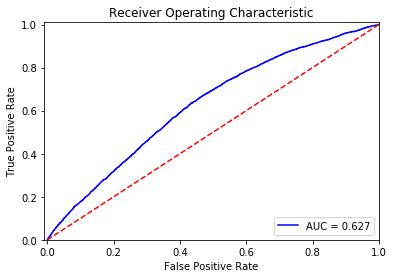

In [75]:
train_preds = lr_train_preds.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = train_preds.prob1
y = train_preds.label
plot_roc(y,preds)

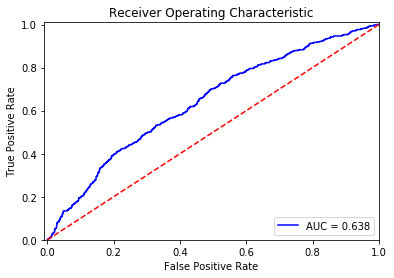

In [76]:
test_preds = lr_test_preds.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = test_preds.prob1
y = test_preds.label
plot_roc(y,preds)

In [110]:
colNames = ['countThumbsUp','percThumbsUp','countThumbsDown','totalThumbs','countLogins',
'countFriends','countErrors','errorsPerLogin','countHelp','helpPerLogin',
'countSong','songsPerLogin','meanLevel']
i=0
print("--- LR Coefficients ---")
for item in model.coefficients:
    print(colNames[i],":",round(item,4))
    i = i+1

--- LR Coefficients ---
countThumbsUp : -0.0065
percThumbsUp : -0.9598
countThumbsDown : 0.0375
totalThumbs : -0.0038
countLogins : -0.0
countFriends : 0.002
countErrors : 0.0017
errorsPerLogin : 0.2119
countHelp : -0.0001
helpPerLogin : -0.0519
countSong : 0.0
songsPerLogin : 0.0028
meanLevel : 0.3329


### Analysis of Logistic Regression

This model is basic but does not appear to be overfit. The nice thing about logistic regression is that it is a simple model that can be resonably interpretable. In order to optimize the model performance a parameter grid search can be used to use some elastic net regularization as well as if an intercept should be fit or not. That should most likely make a more generalizable model that performs well.

### Train Validation Split Logistic Regression

In [77]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

tvs_model = tvs.fit(train)
tvs_train_preds = tvs_model.transform(train)
tvs_test_predictions = tvs_model.transform(validation)

### Train Results

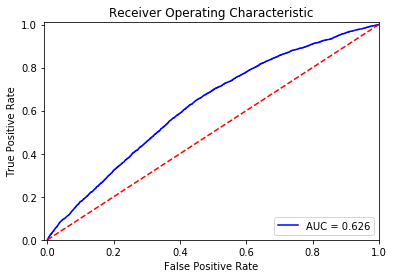

In [78]:
train_preds = tvs_train_preds.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = train_preds.prob1
y = train_preds.label
plot_roc(y,preds)

### Test Results

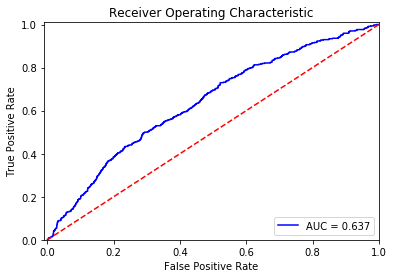

In [79]:
test_preds = tvs_test_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = test_preds.prob1
y = test_preds.label
plot_roc(y,preds)

Extract the parameters that were selected for the best model

In [ ]:
tvs_model.bestModel.extractParamMap()

The best model uses:
 - lr.regParam: 
 - lr.fitIntercept:
 - lr.elasticNetParam:

In [ ]:
i=0
print("--- LR Coefficients ---")
for item in tvs_model.bestModel.coefficients:
    print(colNames[i],":",round(item,4))
    i = i+1

### Analysis of Logistic Regression with Parameter Tuning

This model is basic but does not appear to be overfit. The nice thing about logistic regression is that it is a simple model that doesnt need a huge training dataset to predict well.

## Decision Tree

In [91]:
dt = DecisionTreeClassifier()

model = dt.fit(train)
# Make predictions
gbt_train_predictions = model.transform(train)
gbt_predictions = model.transform(validation)

### Training Results

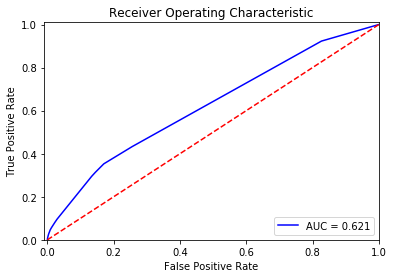

In [92]:
training_preds = gbt_train_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = training_preds.prob1
y = training_preds.label
plot_roc(y,preds)

### Test Results

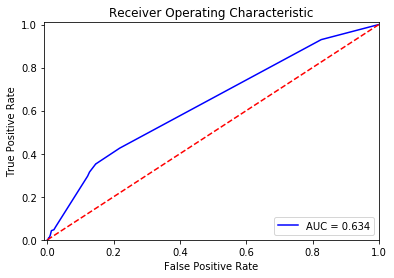

In [93]:
test_preds = gbt_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = test_preds.prob1
y = test_preds.label
plot_roc(y,preds)

### Analysis of Decision Tree 

This model is relatively basic but does not appear to be overfit. The nice thing about Decision Trees compared to Boosted Trees or Random Forrests are that they are a more simple model. The drawback is that in this case they do not provide any boost to our AUC score compared to the Logistic Regression Model.

## GBTree

In [132]:
gbt = GBTClassifier()

model = gbt.fit(train)
# Make predictions
gbt_train_predictions = model.transform(train)
gbt_predictions = model.transform(validation)

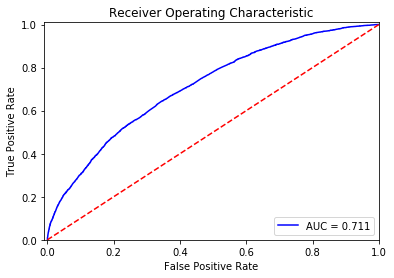

In [133]:
training_preds = gbt_train_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = training_preds.prob1
y = training_preds.label
plot_roc(y,preds)

### Test Results

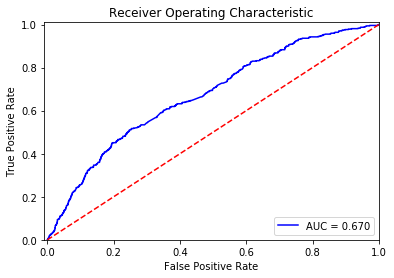

In [134]:
test_preds = gbt_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = test_preds.prob1
y = test_preds.label
plot_roc(y,preds)

### Feature Analysis

In [136]:
featImps = model.featureImportances.toArray()
varNames = ['countThumbsUp','percThumbsUp','countThumbsDown','totalThumbs','countLogins','countFriends',
 'countErrors','errorsPerLogin','countHelp','helpPerLogin','countSong','songsPerLogin','meanLevel']

importance = pd.DataFrame({"FeatureImportance":featImps,"Names":varNames}).sort_values("FeatureImportance")
importance.sort_values("FeatureImportance",ascending = False)

,FeatureImportance,Names
11,0.127641,songsPerLogin
1,0.125787,percThumbsUp
0,0.100788,countThumbsUp
10,0.094991,countSong
12,0.090055,meanLevel
2,0.087694,countThumbsDown
4,0.080849,countLogins
5,0.074564,countFriends
3,0.059361,totalThumbs
9,0.056929,helpPerLogin


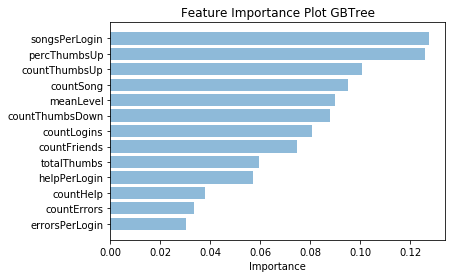

In [137]:
y_pos = np.arange(len(importance.Names))

plt.barh(y_pos, importance.FeatureImportance, align='center', alpha=0.5)
plt.yticks(y_pos, importance.Names)
plt.xlabel('Importance')
plt.title('Feature Importance Plot GBTree')

plt.show()

### Analysis of GBTree Results

This model improves the best AUC we were able to achieve on the training and test sets that we were able to get with Logistic Regression! In order to combat the small overfitting we see with the drop between training and test AUC a parameter grid search can be used to try to optimize hyperparameter tuning similar to what we have done for the Logistic Regression above. Usually this will result in a more generalizable model.

## GBTree with Validation

In [83]:
paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxIter, [10,20,30]) \
    .addGrid(gbt.featureSubsetStrategy, ['all','sqrt','log2'])\
    .addGrid(gbt.maxDepth, [2,3,4])\
    .build()

gbtree_tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

In [84]:
model = gbtree_tvs.fit(train)
# Make predictions
gbt_train_predictions = model.transform(train)
gbt_predictions = model.transform(validation)

In [85]:
model.bestModel.extractParamMap()


{Param(parent='GBTClassifier_a3e13eaf4221', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_a3e13eaf4221', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_a3e13eaf4221', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_a3e13eaf4221', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_a3e13eaf4221', name='labelCol', doc='label column name'): 'la

The best parameters from the grid search are :
 - maxDepth: 3
 - maxIter: 10
 - featureSubsetStrategy: 'all'

### Training Results

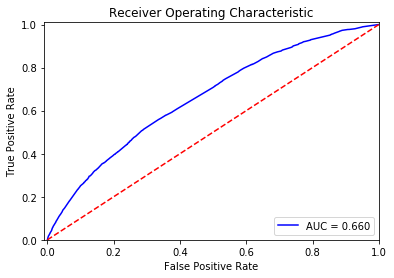

In [86]:
training_preds = gbt_train_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = training_preds.prob1
y = training_preds.label
plot_roc(y,preds)

### Test results

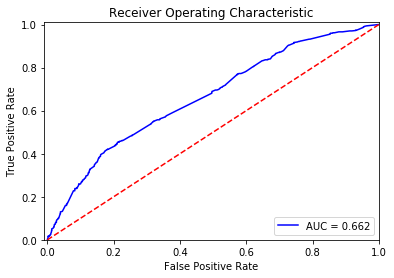

In [87]:
test_preds = gbt_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = test_preds.prob1
y = test_preds.label
plot_roc(y,preds)

### Feature Analysis

In [89]:
featImps = model.bestModel.featureImportances.toArray()
varNames = ['countThumbsUp','percThumbsUp','countThumbsDown','totalThumbs','countLogins','countFriends',
 'countErrors','errorsPerLogin','countHelp','helpPerLogin','countSong','songsPerLogin','meanLevel']

importance = pd.DataFrame({"FeatureImportance":featImps,"Names":varNames}).sort_values("FeatureImportance")
importance.sort_values("FeatureImportance",ascending = False)

,FeatureImportance,Names
1,0.350338,percThumbsUp
11,0.203337,songsPerLogin
4,0.148662,countLogins
12,0.133038,meanLevel
0,0.101154,countThumbsUp
3,0.022925,totalThumbs
9,0.022136,helpPerLogin
2,0.011007,countThumbsDown
7,0.007404,errorsPerLogin
5,0.000000,countFriends


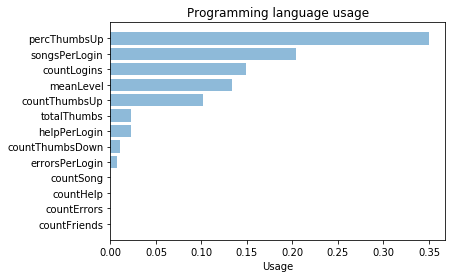

In [90]:
y_pos = np.arange(len(importance.Names))

plt.barh(y_pos, importance.FeatureImportance, align='center', alpha=0.5)
plt.yticks(y_pos, importance.Names)
plt.xlabel('Importance')
plt.title('Feature Importance Plot GBTree')

plt.show()

### Analysis of GBTree with Parameter Tuning

This model with parameter tuning and a validation split performs a little worse than the GBTree model with the default parameters in training but you can see that there is basically no drop off in the test set. I think that this model would be better to use and would generally perform more reliably than the original GBTree model we had.

## GBTree without interaction Features

This will show how the interaction features make a difference in overall AUC score of training and test data

In [124]:
gbt = GBTClassifier()

model = gbt.fit(train_no_interaction)
# Make predictions
gbt_train_predictions = model.transform(train_no_interaction)
gbt_predictions = model.transform(validation_no_interaction)

### Training Results

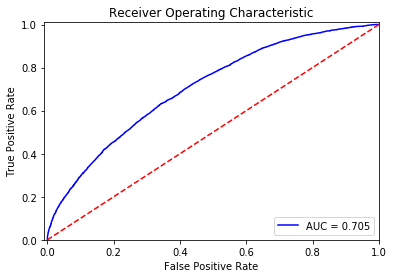

In [125]:
training_preds = gbt_train_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = training_preds.prob1
y = training_preds.label
plot_roc(y,preds)

### Test Results

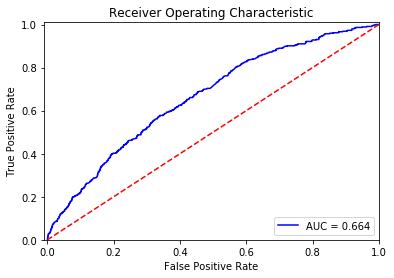

In [131]:
test_preds = gbt_predictions.withColumn('prob0', split0_udf('probability'))\
                                      .withColumn('prob1', split1_udf('probability'))\
                                      .drop('features','rawPrediction','probability')\
                                      .toPandas()
preds = test_preds.prob1
y = test_preds.label
plot_roc(y,preds)

In [127]:
featImps = model.featureImportances.toArray()
varNames = ['countThumbsUp','countThumbsDown','totalThumbs','countLogins',
            'countFriends','countErrors','countHelp','countSong','meanLevel']

importance = pd.DataFrame({"FeatureImportance":featImps,"Names":varNames}).sort_values("FeatureImportance")
importance.sort_values("FeatureImportance",ascending = False)

,FeatureImportance,Names
7,0.208740,countSong
1,0.157553,countThumbsDown
0,0.155859,countThumbsUp
3,0.122085,countLogins
8,0.097186,meanLevel
6,0.093070,countHelp
4,0.069811,countFriends
2,0.065981,totalThumbs
5,0.029715,countErrors


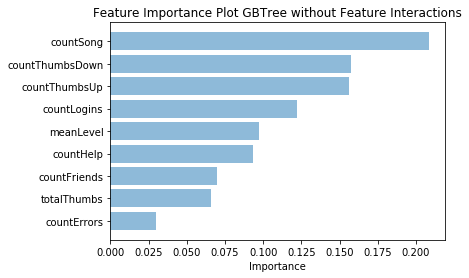

In [128]:
y_pos = np.arange(len(importance.Names))

plt.barh(y_pos, importance.FeatureImportance, align='center', alpha=0.5)
plt.yticks(y_pos, importance.Names)
plt.xlabel('Importance')
plt.title('Feature Importance Plot GBTree without Feature Interactions')

plt.show()